In [1]:
import os
import time
import math
import re
import struct
import traceback
import codecs
import io

import bitstring

import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from list_char import JIS0208
from hiragana import basic_hiragana_char
import IPython.display as display

In [2]:
file_list = [
    'ETL8G' + '\\ETL8G_01',
    'ETL8G' + '\\ETL8G_02',
    'ETL8G' + '\\ETL8G_03',
    'ETL8G' + '\\ETL8G_04',
    'ETL8G' + '\\ETL8G_05',
    'ETL8G' + '\\ETL8G_06',
    'ETL8G' + '\\ETL8G_07',
    'ETL8G' + '\\ETL8G_08',
    'ETL8G' + '\\ETL8G_09',
    'ETL8G' + '\\ETL8G_10',
    'ETL8G' + '\\ETL8G_11',
    'ETL8G' + '\\ETL8G_12',
    'ETL8G' + '\\ETL8G_13',
    'ETL8G' + '\\ETL8G_14',
    'ETL8G' + '\\ETL8G_15',
    'ETL8G' + '\\ETL8G_16',
    'ETL8G' + '\\ETL8G_17',
    'ETL8G' + '\\ETL8G_18',
    'ETL8G' + '\\ETL8G_19',
    'ETL8G' + '\\ETL8G_20',
    'ETL8G' + '\\ETL8G_21',
    'ETL8G' + '\\ETL8G_22',
    'ETL8G' + '\\ETL8G_23',
    'ETL8G' + '\\ETL8G_24',
    'ETL8G' + '\\ETL8G_25',
    'ETL8G' + '\\ETL8G_26',
    'ETL8G' + '\\ETL8G_27',
    'ETL8G' + '\\ETL8G_28',
    'ETL8G' + '\\ETL8G_29',
    'ETL8G' + '\\ETL8G_30',
    'ETL8G' + '\\ETL8G_31',
    'ETL8G' + '\\ETL8G_32',
    'ETL8G' + '\\ETL8G_33'
]

In [3]:
file_stream = bitstring.ConstBitStream(filename=file_list[0])

In [4]:
record = file_stream.readlist(',' . join([
    'int:16', # Serial Sheet Number - [0]
    'uint:64', # JIS Character Code (JIS X 0208) - [1]
    '8*uint:8', # JIS Typical Reading (e.g. 'AI.MEDER') - [2:10]
    'int:32', # Serial Data Number - [10]
    '4*int:8', # - [11:15]
    '4*uint:16', # - [15:19]
    '2*int:8', # x and y - [19:21]
    'pad:240',
    'bytes:8128', # 16-graylevel (4-bit) image of 128 x 127 = 16256 pixels
    'pad:88',
]))
record[20]

-110

In [5]:
record_dict = {
    'JIS_CODE': record[1],
    'image_data' : record[-1]
}

In [6]:
print(type(record), len(record))
for idx, v in enumerate(record[:-1]):
    print(f'{idx} - {v}')

<class 'list'> 22
0 - 1
1 - 2603715201610633793
2 - 32
3 - 32
4 - 0
5 - 0
6 - 0
7 - 1
8 - 0
9 - 0
10 - 18353632
11 - 0
12 - 0
13 - 31
14 - 65
15 - 16880
16 - 0
17 - 6
18 - 24206
19 - 94
20 - -110


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


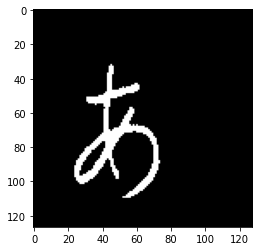

In [7]:
width = 128
height = 127

img = np.array(Image.frombytes('F', (width, height), record_dict['image_data'], 'bit', 4))
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


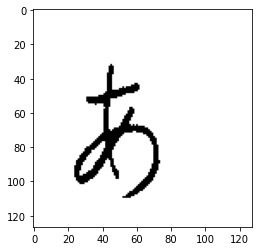

In [8]:
# Reverse binarization
avg_color_per_row = np.average(img, axis=0)
avg_color = np.average(avg_color_per_row, axis=0)

for idx1, first_iter in enumerate(img):
    for idx2, second_iter in enumerate(first_iter):
        for idx3, third_iter in enumerate(second_iter):
            if third_iter <= np.round(avg_color[idx3]):
                img[idx1][idx2][idx3] = 255
            else:
                img[idx1][idx2][idx3] = 0
                
plt.imshow(img)

In [9]:
# Reverse binarization function
def reverse_binarization(pil_image):
    img = cv2.cvtColor(pil_image, cv2.COLOR_GRAY2RGB)
    avg_color_per_row = np.average(img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)

    for idx1, first_iter in enumerate(img):
        for idx2, second_iter in enumerate(first_iter):
                for idx3, third_iter in enumerate(second_iter):
                    if third_iter <= np.round(avg_color[idx3]):
                        img[idx1][idx2][idx3] = 255
                    elif third_iter <= np.round(avg_color[idx3]) + 1:
                        img[idx1][idx2][idx3] = 255
                    else:
                        img[idx1][idx2][idx3] = 0
    return img

In [10]:
total_samples = 0
record_count = {}
save_dir = 'ETL8G\\IMG'
distinct_idx = 0

for filename in file_list:
    file_stream = bitstring.ConstBitStream(filename=filename)
    
    while True:
        try:
            record = file_stream.readlist(','.join([
                'int:16', # Serial Sheet Number - [0]
                'uint:16', # JIS Character Code (JIS X 0208) - [1]
                '8*uint:8', # JIS Typical Reading (e.g. 'AI.MEDER') - [2:10]
                'int:32', # Serial Data Number - [10]
                '4*int:8', # - [11:15]
                '4*uint:16', # - [15:19]
                '2*int:8', # x and y - [19:21]
                'pad:240',
                'bytes:8128', # 16-graylevel (4-bit) image of 128 x 127 = 16256 pixels
                'pad:88'
            ]))
        except:
            break

        total_samples += 1
        record_dict = {
            'SERIAL_SHEET': record[0],
            'JIS_CODE': record[1],
            'JIS_READING': record[2:10],
            'image_data': record[-1],
        }

        # Sheet Number
        sheet_number = record_dict['SERIAL_SHEET']

        # Unicode
        jis_code = hex(record_dict['JIS_CODE'])
        unicode = int(str(jis_code), base=16)
        if unicode in JIS0208:
            unicode_char = JIS0208[unicode]
        else:
            unicode_char = 'null_' + repr(unicode)

        if jis_code in record_count.keys():
            record_count[jis_code] += 1
        else:
            record_count[jis_code] = 1

        # Get the Jist Reading
        jis_reading = record_dict['JIS_READING']
        jis_reading = ''.join(list(map(chr, jis_reading)))

        # Image Data\n",
        image = record_dict['image_data']
        pil_image = np.array(Image.frombytes('F', (width, height), image, 'bit', 4))
        buffer = io.BytesIO()
        png_encoded_image = buffer.getvalue()

        # Filename for saving directories also\n",
        #filename = str(sheet_number) + "_" + str(jis_reading) + "_" + hiragana + "_hira" + ".png"

        for idx, chara in enumerate(basic_hiragana_char):
            if unicode_char == basic_hiragana_char[idx].split("-")[0]:
                filename = str(distinct_idx) + "_" + basic_hiragana_char[idx] + "_hira" + ".png"
                filename = os.path.join(save_dir, filename)
                #pil_image.save(filename)
                
                img = reverse_binarization(pil_image)
                cv2.imwrite(filename, img)

                distinct_idx += 1

In [14]:
basic_hiragana_char[0].split("-")[0]

'あ'